#### Survival analysis is used to estimate the time unitl an event occurs

In [1]:
from scipy.stats import weibull_min

# Survival analysis uses 
def weibull_dist(lam, k):
    return weibull_min(k, scale=lam)

In [2]:
lam = 3
k = 0.8
actual_dist = weibull_dist(lam, k)

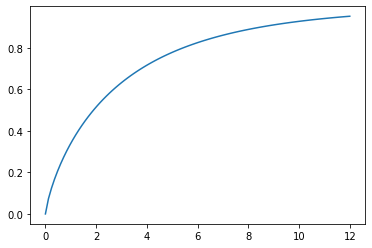

In [22]:
import numpy as np
from empiricaldist import Cdf, Pmf
import matplotlib.pyplot as plt
import pandas as pd

qs = np.linspace(0, 12, 101)
ps = actual_dist.cdf(qs)
cdf = Cdf(ps, qs)
cdf.plot()
plt.show()

In [13]:
# Helper functions
def make_joint(pmf1, pmf2):
    """Compute the outer product of two Pmfs."""
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

In [14]:
def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [38]:
data = actual_dist.rvs(10)
data

array([0.24760202, 0.41286871, 1.72602844, 5.01035522, 3.1993952 ,
       0.16164168, 0.37229834, 1.86019257, 2.519334  , 2.11426433])

In [39]:
lams = np.linspace(0.1, 10.1, num=101)
prior_lam = make_uniform(lams, name='lambda')

ks = np.linspace(0.1, 5.1, num=101)
prior_k = make_uniform(ks, name='k')

In [40]:
prior = make_joint(prior_lam, prior_k)

In [41]:
lam_mesh, k_mesh, data_mesh = np.meshgrid(
    prior.columns, prior.index, data)

In [59]:
densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
densities.shape

(101, 101, 10)

In [61]:
likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)

In [67]:
posterior = prior * likelihood
posterior /= posterior.values.sum()

In [70]:
def update_weibull(prior, data):
    """Update the prior based on data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)

    posterior = prior * likelihood
    posterior /= posterior.values.sum()

    return posterior

In [106]:
data = actual_dist.rvs(10)

In [107]:
posterior = update_weibull(prior, data)

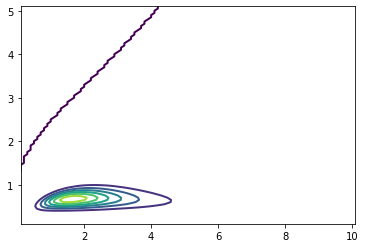

In [108]:
plt.contour(posterior.columns, posterior.index, posterior,
            linewidths=2)
plt.show()

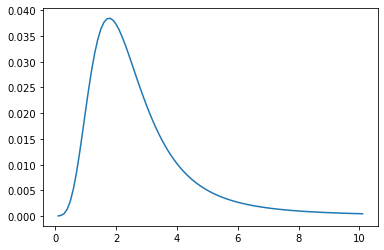

In [109]:
posterior_lam = posterior.sum(axis=0)
posterior_lam /= posterior_lam.sum()
posterior_lam.plot()
plt.show()

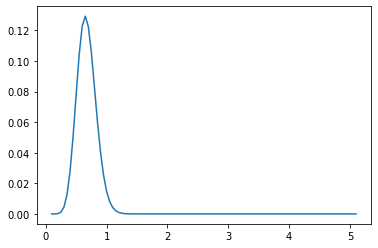

In [110]:
posterior_k = posterior.sum(axis=1)
posterior_k /= posterior_k.sum()
posterior_k.plot()
plt.show()

### Incomplete Data

In [169]:
# Define the observation time to be 8 weeks, thus anything after 8 weeks is censored
start = np.random.uniform(0, 8, size=10)
duration = actual_dist.rvs(10)

d = dict(start=start, end=start+duration)
obs = pd.DataFrame(d)
obs = obs.sort_values(by='start', ignore_index=True)
obs

,start,end
0,0.660783,6.093896
1,1.750737,1.862404
2,2.414981,4.673996
3,2.945280,4.094805
4,3.732952,9.478876
5,4.905102,6.473492
6,5.289421,11.735868
7,5.441876,5.665302
8,5.639647,5.761571
9,5.926657,6.435373


In [170]:
censored = obs['end'] > 8
obs.loc[censored, 'end'] = 8
obs.loc[censored, 'status'] = 0
obs

,start,end,status
0,0.660783,6.093896,NaN
1,1.750737,1.862404,NaN
2,2.414981,4.673996,NaN
3,2.945280,4.094805,NaN
4,3.732952,8.000000,0.0
5,4.905102,6.473492,NaN
6,5.289421,8.000000,0.0
7,5.441876,5.665302,NaN
8,5.639647,5.761571,NaN
9,5.926657,6.435373,NaN


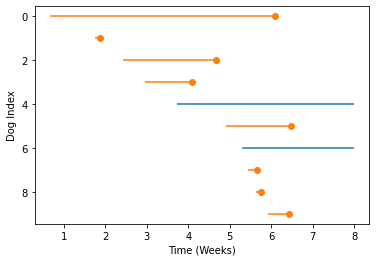

In [171]:
def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            # ongoing
            plt.hlines(y, start, end, color='C0')
        else:
            # complete
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
    plt.xlabel('Time (Weeks)')
    plt.ylabel('Dog Index')

    plt.gca().invert_yaxis()

plot_lifelines(obs)

In [172]:
obs['T'] = obs['end'] - obs['start']
obs

,start,end,status,T
0,0.660783,6.093896,NaN,5.433112
1,1.750737,1.862404,NaN,0.111667
2,2.414981,4.673996,NaN,2.259015
3,2.945280,4.094805,NaN,1.149525
4,3.732952,8.000000,0.0,4.267048
5,4.905102,6.473492,NaN,1.568389
6,5.289421,8.000000,0.0,2.710579
7,5.441876,5.665302,NaN,0.223426
8,5.639647,5.761571,NaN,0.121924
9,5.926657,6.435373,NaN,0.508716


In [173]:
data1 = obs.loc[~censored, 'T'] # Departure times are known
data2 = obs.loc[censored, 'T'] # Not known

In [174]:
posterior1 = update_weibull(prior, data1)

To utilize incomplete data, use the weibull survivor function, which is the probability that a value from the distribtuion exceeds T

In [175]:
def update_weibull_incomplete(prior, data):
    """Update the prior using incomplete data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    # evaluate the survival function
    probs = weibull_dist(lam_mesh, k_mesh).sf(data_mesh)
    likelihood = probs.prod(axis=2)

    posterior = prior * likelihood
    posterior /= posterior.sum()

    return posterior

In [176]:
weibull_dist(5, 2).sf(2)

0.8521437889662113

In [177]:
# As expected, the survivor function is 1 - cdf
1-weibull_dist(5, 2).cdf(2)

0.8521437889662113

In [178]:
posterior2 = update_weibull_incomplete(posterior1, data2)

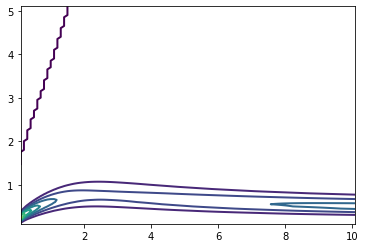

In [179]:
plt.contour(posterior2.columns, posterior2.index, posterior2,
            linewidths=2,levels=10)
plt.show()

### Lamps

In [180]:
df = pd.read_csv('lamps.csv')
df.head()

,i,h,f,K
0,0,0,0,50
1,1,840,2,48
2,2,852,1,47
3,3,936,1,46
4,4,960,1,45


In [181]:
pmf_bulb = Pmf(df['f'].to_numpy(), df['h'])
pmf_bulb.normalize()

50

In [207]:
lams = np.linspace(1000, 2000, num=51)
prior_lam = make_uniform(lams, name='lambda')

ks = np.linspace(1, 10, num=51)
prior_k = make_uniform(ks, name='k')

In [208]:
prior_bulb = make_joint(prior_lam, prior_k)

In [209]:
data_bulb = np.repeat(df['h'], df['f'])
len(data_bulb)

50

In [210]:
posterior_bulb = update_weibull(prior_bulb, data_bulb)

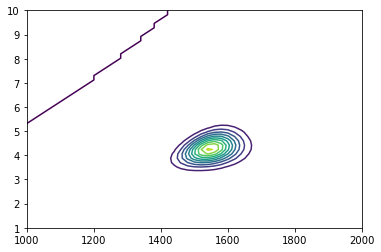

In [211]:
plt.contour(posterior_bulb.columns, posterior_bulb.index, posterior_bulb,levels=10)
plt.show()

In [216]:
# Posterior Means
lam_mesh, k_mesh = np.meshgrid(
    prior_bulb.columns, prior_bulb.index)

means = weibull_dist(lam_mesh, k_mesh).mean()
prod = means * posterior_bulb

prod.to_numpy().sum() # Weighted average for mean lifetime

1412.7242774305005

### Posterior Predictive

In [227]:
from scipy.stats import binom
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

In [228]:
posterior_series = posterior_bulb.stack() # Row wise stacking, first one on top of second row and etc.
posterior_series.head()

1.0  1000.0    8.146763e-25
     1020.0    1.210486e-24
     1040.0    1.738327e-24
     1060.0    2.418201e-24
     1080.0    3.265549e-24
dtype: float64

In [229]:
# Compute a predictive distribution for each pair
n, t = 100, 1000 # Check back on 100 bulbs after 1,000 hours
pmf_seq = []
for (k, lam) in posterior_series.index:
    prob_dead = weibull_dist(lam, k).cdf(t)
    pmf = make_binomial(n, prob_dead)
    pmf_seq.append(pmf)

In [232]:
# Mixture of 2,601 (51^2) binomial distributions
post_pred = make_mixture(posterior_series, pmf_seq)

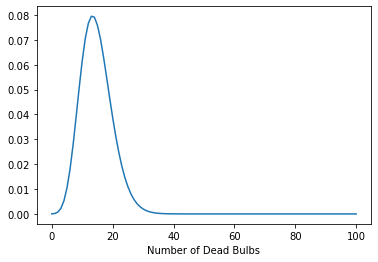

In [236]:
post_pred.plot(xlabel='Number of Dead Bulbs')
plt.show()